In [1006]:
timestamp()

##------ Wed Mar 18 13:09:03 2020 ------##


In [1007]:
library(tidyverse)
library(lubridate)

In [1008]:
PATH = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series"
FILE_TEMPLATE = "time_series_19-covid-%s.csv"
make_path = function(path, file_template, filetype) {
    file = sprintf(file_template, filetype)
    return(sprintf('%s/%s', path, file))
    }

confirmed_path = make_path(PATH, FILE_TEMPLATE, 'Confirmed')
deaths_path = make_path(PATH, FILE_TEMPLATE, 'Deaths')
recovered_path = make_path(PATH, FILE_TEMPLATE, 'Recovered')

confirmed_raw = read.csv(confirmed_path, header=T, as.is=T)
deaths_raw = read.csv(deaths_path, header=T, as.is=T)
recovered_raw = read.csv(recovered_path, header=T, as.is=T)

In [1009]:
prepare_file = function(file, value_name) {
    file = select(file, -c(Lat, Long))
    tmp = pivot_longer(file, 
                       names_to='date', 
                       values_to=value_name,
                       cols=-c('Province.State', 'Country.Region'),
                       names_prefix='X')
    tmp = mutate(tmp, 
                 date=mdy(date)
                )
    tmp$Province.State[tmp$Province.State == ''] = 'None'
    names(tmp)[c(1,2)] = c('state', 'country')
    return(tmp)
}

confirmed = prepare_file(confirmed_raw, 'confirmed')
deaths = prepare_file(deaths_raw, 'deaths')
recovered = prepare_file(recovered_raw, 'recovered')

dat = inner_join(inner_join(confirmed, 
                            deaths, 
                            by=c("state", "country", "date")), 
                 recovered, c("state", "country", "date"))  %>%
mutate(days = as.numeric(date - min(date)))

In [1010]:
STATES_WITH_ABBREV = 
list(c('California', 'CA'),
c('New York', 'NY'),
c('New Jersey', 'NJ'),
c('Washington', 'WA'),
c('Massachusetts', 'MA'),
c('Louisiana', 'LA'),
c('Colorado', 'CO'),
c('Florida', 'FL'),
c('Illinois', 'IL'),
c('Georgia', 'GA'),
c('Texas', 'TX'),
c('Pennsylvania', 'PA'))

STATE_ABBREV_MAP = as.data.frame(do.call(rbind, STATES_WITH_ABBREV))
names(STATE_ABBREV_MAP) = c('state', 'state_abbrev')
STATE_ABBREV_MAP = mutate(STATE_ABBREV_MAP,
                          state=as.character(state),
                          state_abbrev=as.character(state_abbrev))

In [1011]:
STATE_ABBREV_MAP

state,state_abbrev
California,CA
New York,NY
New Jersey,NJ
Washington,WA
Massachusetts,MA
Louisiana,LA
Colorado,CO
Florida,FL
Illinois,IL
Georgia,GA


In [1012]:
# Do some grouping by states in the US
STATE_ABBREVS = unique(STATE_ABBREV_MAP$state_abbrev)
dat_state = left_join(dat, STATE_ABBREV_MAP, by='state') 

insert_abbrev = function(long_name, abbrev, target_vector) {
    # for each element of long_name matching abbrev, 
    # replaces target_vector with abbrev
    target_vector[grep(abbrev, long_name)] = abbrev
    return(target_vector)
}

for(abbrev in STATE_ABBREVS) {
    dat_state$state_abbrev = insert_abbrev(dat_state$state, 
                                           abbrev, 
                                           dat_state$state_abbrev)
}

country_level = group_by(dat, country, date, days) %>%
summarize(confirmed=sum(confirmed),
          deaths=sum(deaths),
          recovered=sum(recovered)) %>%
mutate(death_rate = deaths / confirmed, # yes I know this is a naive estimate
       recovery_rate = recovered / confirmed)

state_level = group_by(dat_state, state_abbrev, date, days) %>%
summarize(confirmed=sum(confirmed),
          deaths=sum(deaths),
          recovered=sum(recovered)) %>%
mutate(death_rate = deaths / confirmed,
       recovery_rate = recovered / confirmed)


In [1013]:
# some constants to use for plotting and modeling
PER_COUNTRY_CONFIRMED_CASES_MINIMUM = 1000 # show only countries with at least this many confirmed cases
PER_DAY_CONFIRMED_CASES_MINIMUM = 20 # plot / model only the time series with at least this many confirmed cases
CONFIRMED_CASES_MINIMUM_TO_SHOW_DEATH_RATE = 200 # plot death rates only when confirmed cases is at least this
FORECAST_HORIZON = 7 # how many days ahead to forecast

In [1014]:
COUNTRIES = unique(country_level$country[country_level$confirmed >= 
                                         PER_COUNTRY_CONFIRMED_CASES_MINIMUM])

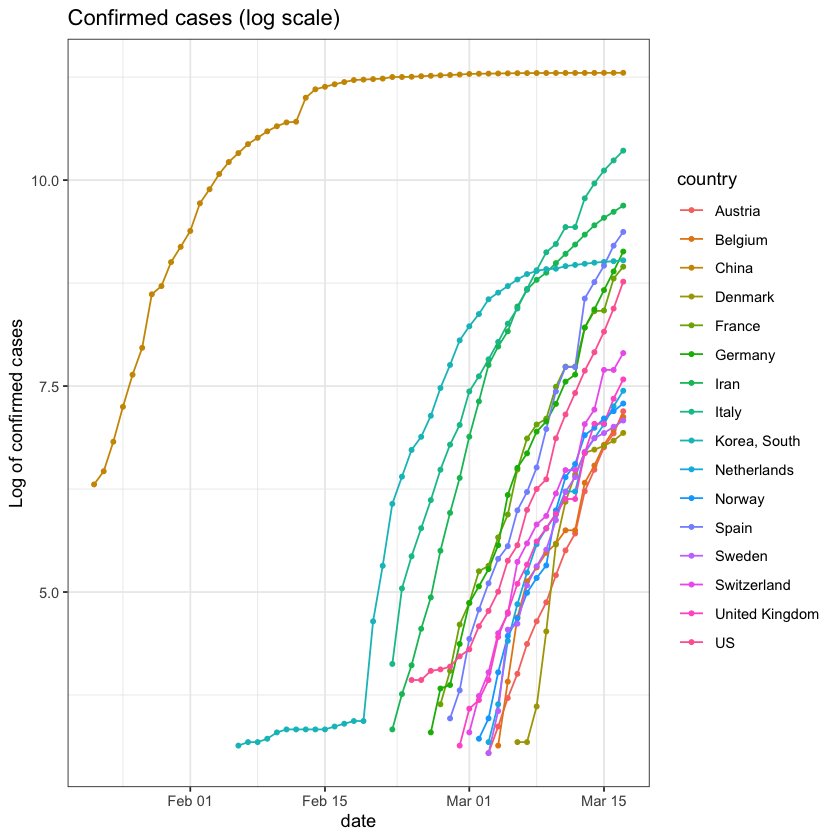

In [1015]:
filter(country_level, 
       country %in% COUNTRIES, confirmed > 
       PER_DAY_CONFIRMED_CASES_MINIMUM) %>%
ggplot(aes(x=date, y=log(confirmed), color=country)) + geom_line() + geom_point(size=1) +
ylab('Log of confirmed cases') +
ggtitle("Confirmed cases (log scale)")

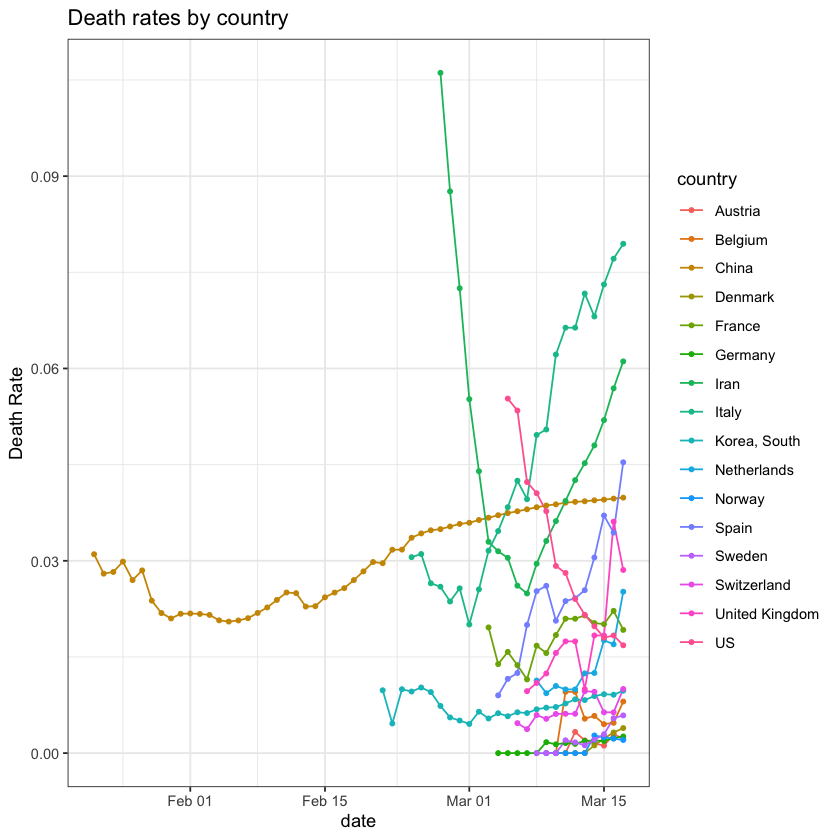

In [1016]:
filter(country_level, country %in% COUNTRIES, 
       confirmed > CONFIRMED_CASES_MINIMUM_TO_SHOW_DEATH_RATE) %>%
ggplot(aes(x=date, y=death_rate, color=country)) + geom_line() + geom_point(size=1) +
ylab('Death Rate') +
ggtitle("Death rates by country")

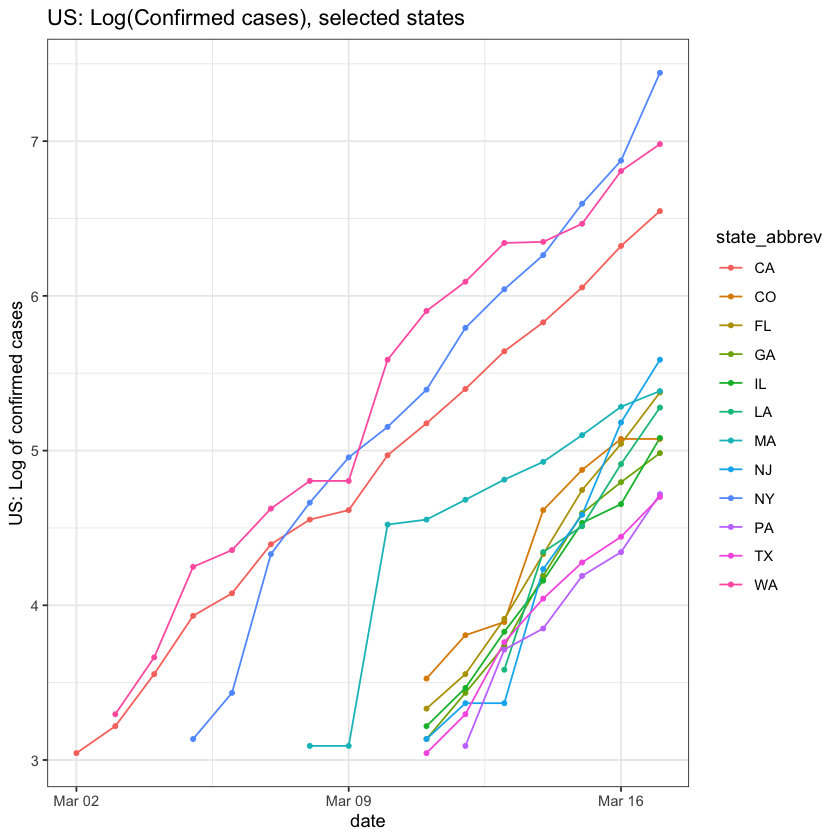

In [1017]:
filter(state_level,
       confirmed > PER_DAY_CONFIRMED_CASES_MINIMUM, 
       !is.na(state_abbrev) ) %>%
ggplot(aes(x=date, y=log(confirmed), color=state_abbrev)) + geom_line() + geom_point(size=1) +
ylab('US: Log of confirmed cases') +
ggtitle("US: Log(Confirmed cases), selected states")

In [1018]:
regression_one_region = function(df) {
    # df is the data for one state or country
    df = filter(df, confirmed > 5)
    summarize(df, confirmed=sum(confirmed))
    reg = lm(log(confirmed) ~ days, data=df)
    ans = data.frame(coef=summary(reg)$coef[2,1])
    return(mutate(ans, growth=exp(coef), doubling_time=log(2)/coef))
}

Look at the growth rates by country

In [1019]:
filter(country_level, 
       country %in% COUNTRIES) %>%
group_by(country) %>%
do(regression_one_region(.))

country,coef,growth,doubling_time
Austria,0.29644705,1.345071,2.338182
Belgium,0.31272728,1.367149,2.216459
China,0.06839644,1.070790,10.134257
Denmark,0.41583974,1.515643,1.666861
France,0.16806906,1.183018,4.124181
Germany,0.15320119,1.165559,4.524424
Iran,0.27624537,1.318171,2.509172
Italy,0.25182420,1.286370,2.752504
"Korea, South",0.18335480,1.201241,3.780360
Netherlands,0.32418401,1.382902,2.138129


Look at the growth rates by state in the US (for selected states)

In [1020]:
filter(state_level, !is.na(state_abbrev)) %>%
group_by(state_abbrev) %>%
do(regression_one_region(.))

state_abbrev,coef,growth,doubling_time
CA,0.1048912,1.110590,6.608247
CO,0.3739167,1.453416,1.853748
FL,0.3497758,1.418749,1.981690
GA,0.3381123,1.402298,2.050050
IL,0.3545292,1.425509,1.955120
LA,0.5472442,1.728483,1.266614
MA,0.3328159,1.394891,2.082674
NJ,0.4155436,1.515194,1.668049
NY,0.3479792,1.416203,1.991921
PA,0.3363931,1.399889,2.060527


In [1021]:
forecast_region = function(df, 
                           region, 
                           region_type, 
                           horizon=FORECAST_HORIZON,
                           minimum_cases=PER_DAY_CONFIRMED_CASES_MINIMUM) {
    if(region_type  == 'state') {
        df = filter(df, state_abbrev == region)
        }
        else {
            df = filter(df, country == region)
            }
    day_of_present = max(df$days)
    date_of_present = max(df$date)
    future = data.frame(days=day_of_present + (1:horizon), 
                    date=date_of_present + (1:horizon),
                    period='future',
                    confirmed=NA)
    past = 
    ungroup(df) %>%
    filter(confirmed >= minimum_cases) %>%
    select(days, date, confirmed) %>%
    mutate(period='past') 
    reg = lm(log(confirmed) ~ days, data=past)
    forecast_data = rbind(past, future)
    forecast_data$lpred = predict(reg, newdata=forecast_data)
    forecast_data = mutate(forecast_data,
                       pred=exp(lpred))
    predicted = mutate(forecast_data,
                   type='predicted')
    actual = filter(forecast_data, period=='past') %>%
         mutate(type='actual')
    both = rbind(actual, predicted) %>%
    mutate(cases = ifelse(type=='actual', confirmed, pred))
    ggplot(data=both,
       aes(x=date, y=cases, color=type)) + 
    geom_line(alpha=.5) + 
    geom_point(size=1, alpha=.5) +
    geom_vline(xintercept=date_of_present, color='black', lty=2) +
    ggtitle(sprintf("Forecast for %s", region))
    }


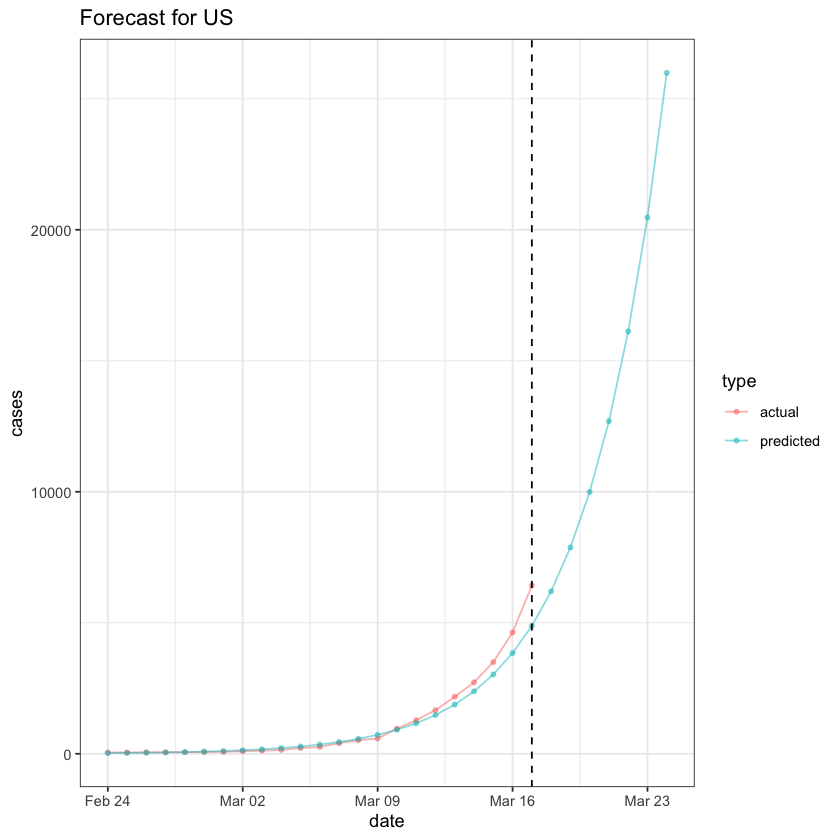

In [1022]:
forecast_region(df=country_level,
                region='US',
                region_type='country')

Selected state-level forecasts:

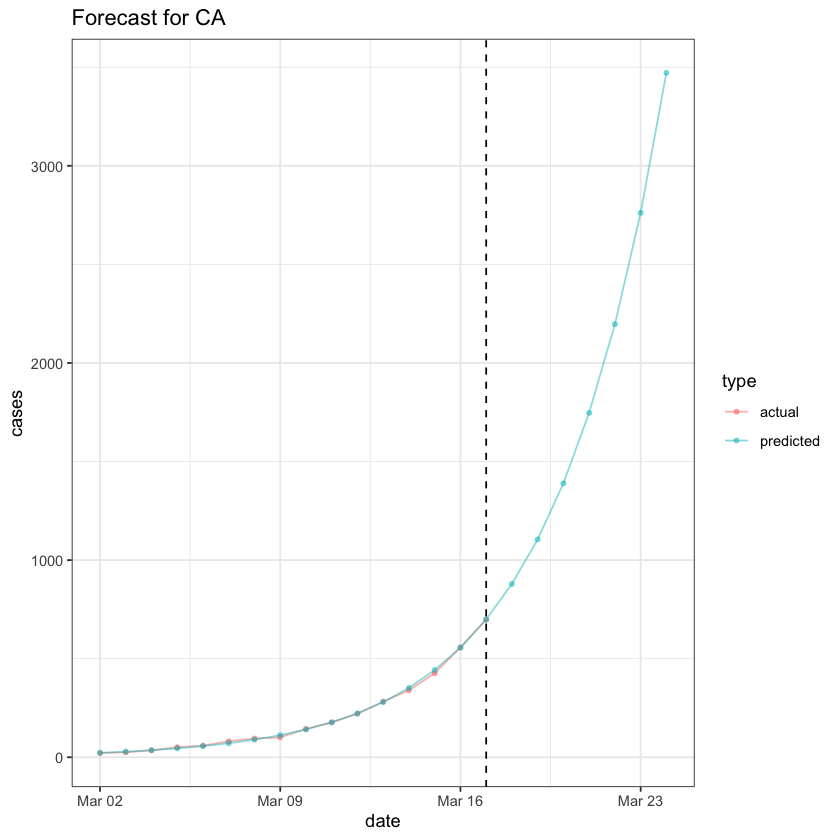

In [1023]:
forecast_region(df=state_level,
                region='CA',
                region_type='state')

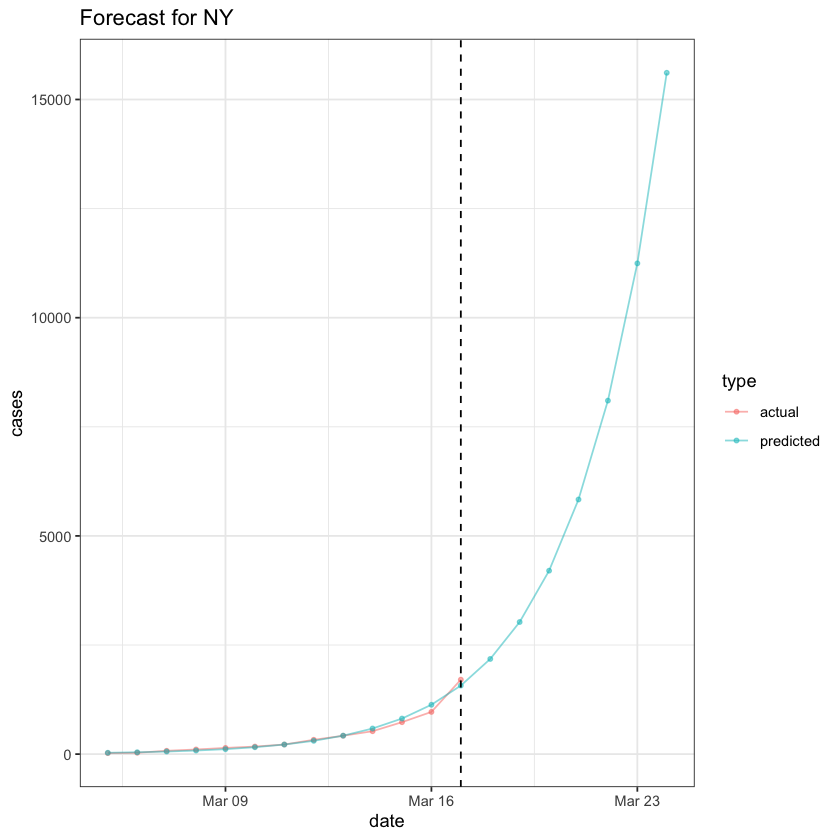

In [1024]:
forecast_region(df=state_level,
                region='NY',
                region_type='state')

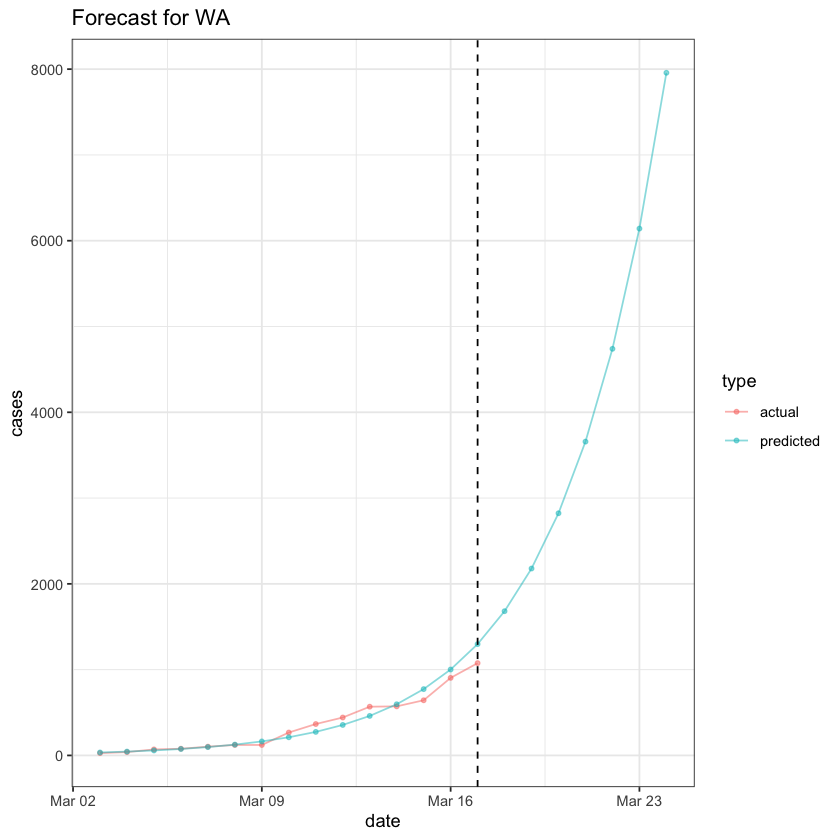

In [1025]:
forecast_region(df=state_level,
                region='WA',
                region_type='state')

Selected country-level forecasts:

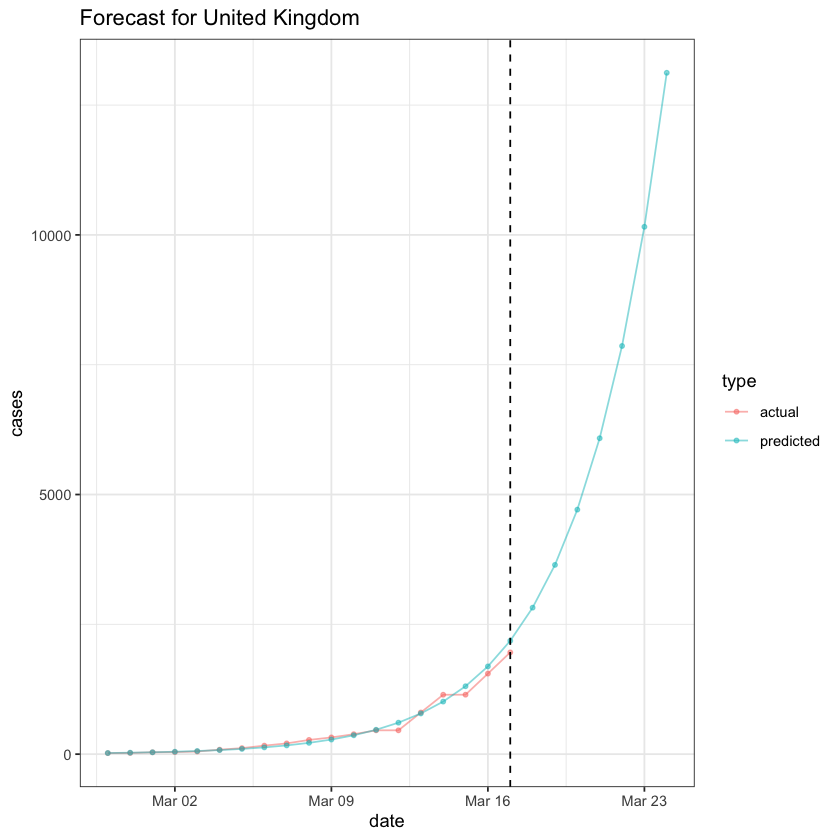

In [1026]:
forecast_region(df=country_level,
                region='United Kingdom',
                region_type='country')

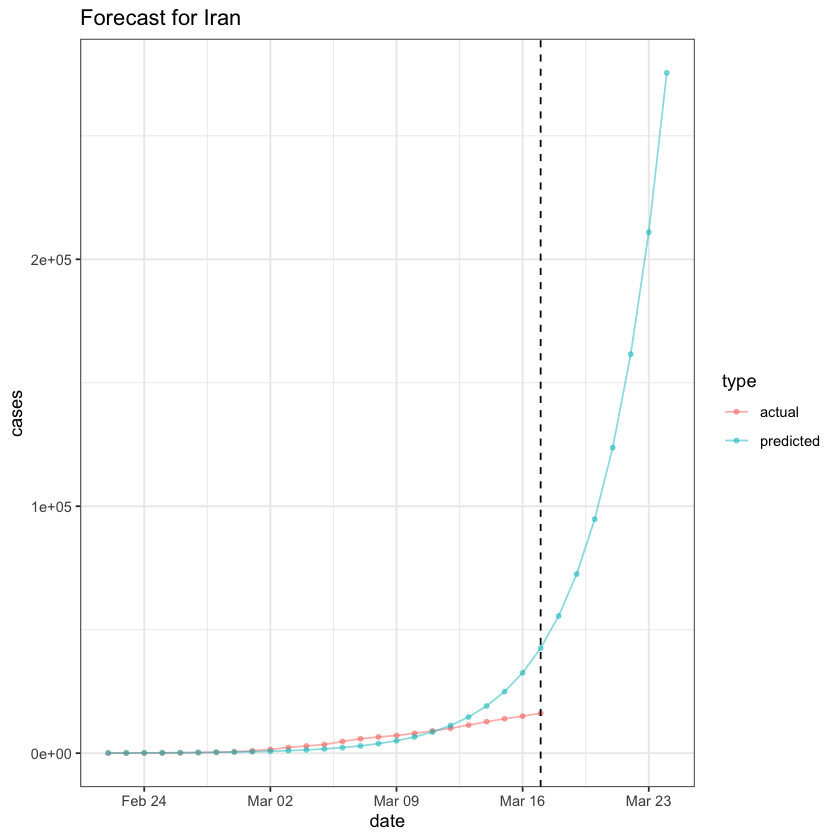

In [1027]:
forecast_region(df=country_level,
                region='Iran',
                region_type='country')

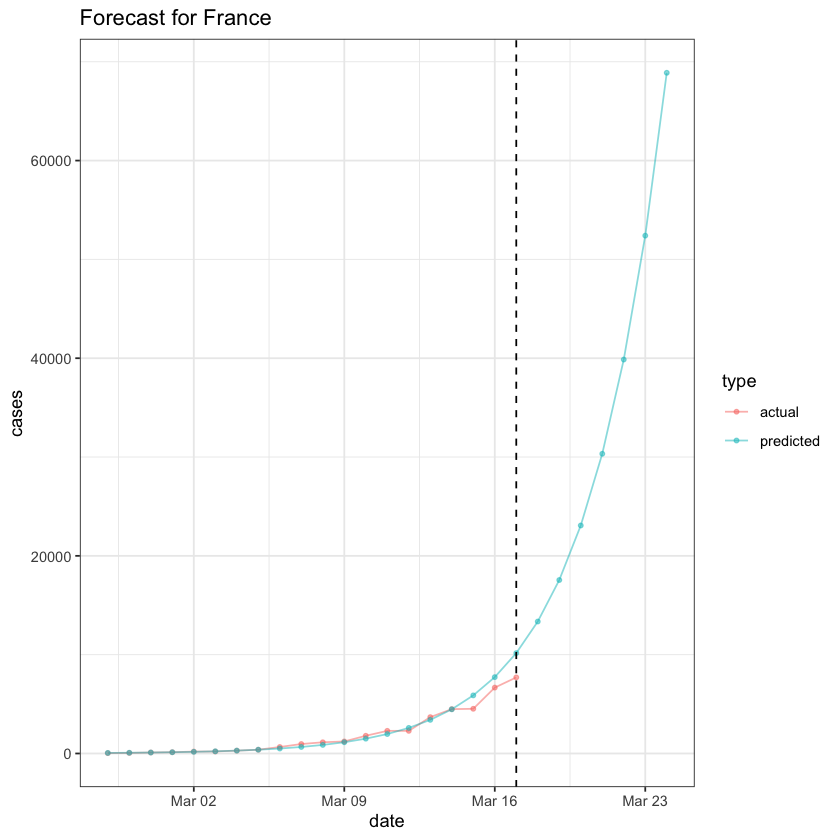

In [1028]:
forecast_region(df=country_level,
                region='France',
                region_type='country')

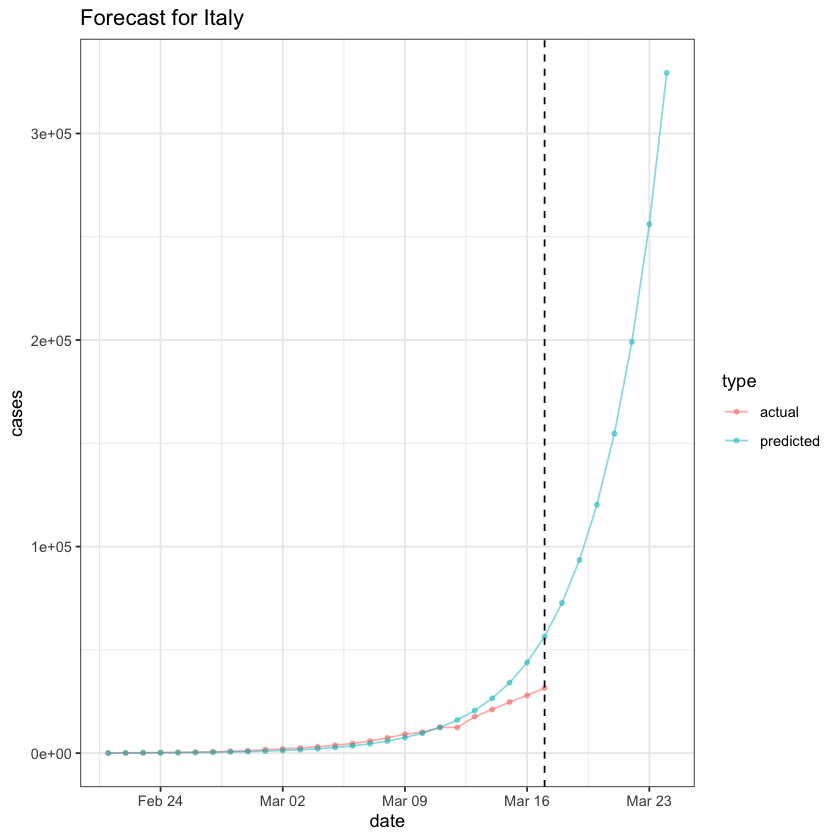

In [1029]:
forecast_region(df=country_level,
                region='Italy',
                region_type='country')

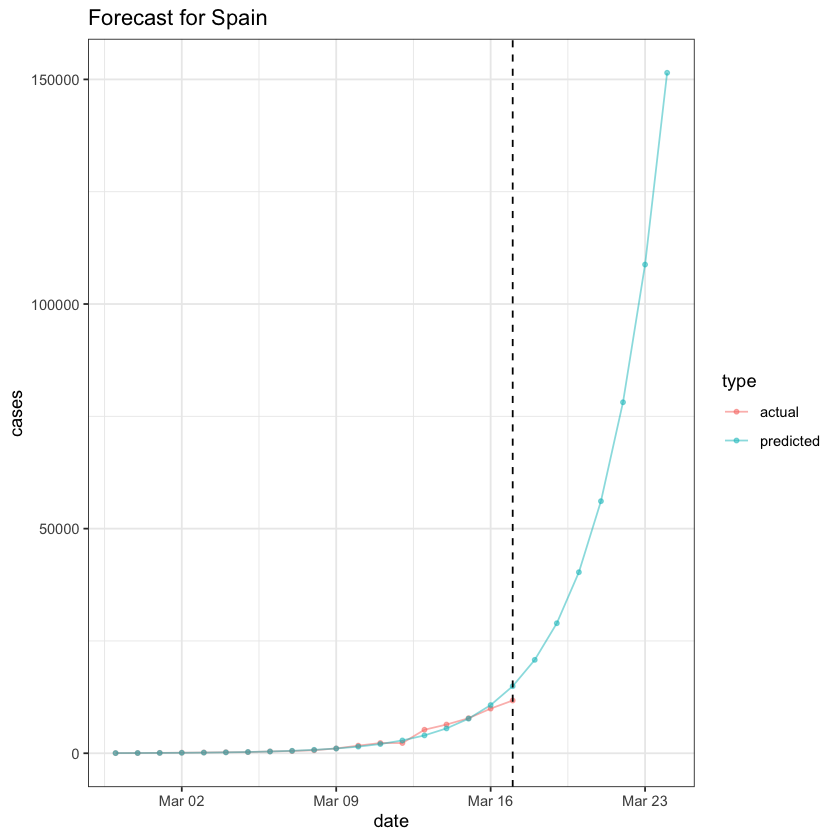

In [1030]:
forecast_region(df=country_level,
                region='Spain',
                region_type='country')

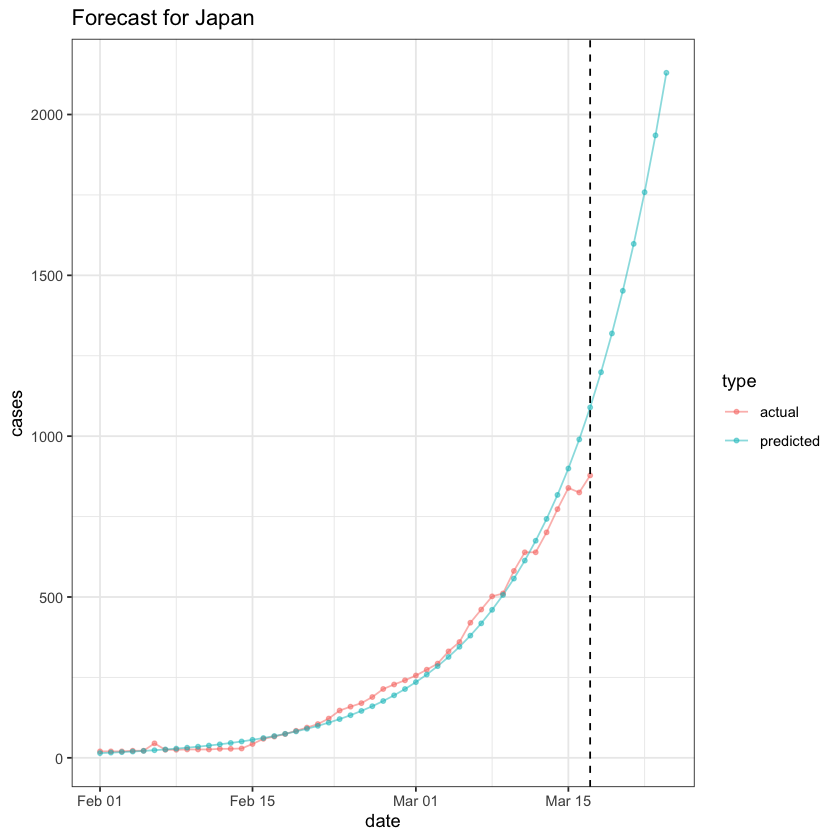

In [1031]:
forecast_region(df=country_level,
                region='Japan',
                region_type='country')

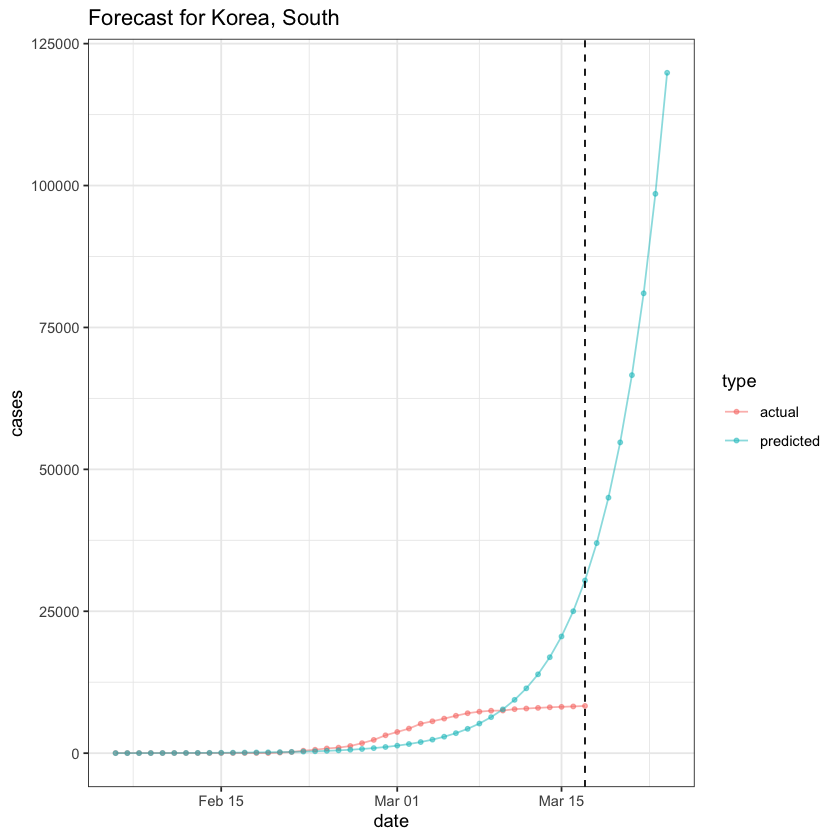

In [1032]:
forecast_region(df=country_level,
                region='Korea, South',
                region_type='country')